In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image


In [ ]:
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [ ]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
data_dir = '/content/drive/MyDrive/bloodcells_dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    if fold in ['ig', 'neutrophil']:
        continue
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
df.head()

,filepaths,labels
0,/content/drive/MyDrive/bloodcells_dataset/mono...,monocyte
1,/content/drive/MyDrive/bloodcells_dataset/mono...,monocyte
2,/content/drive/MyDrive/bloodcells_dataset/mono...,monocyte
3,/content/drive/MyDrive/bloodcells_dataset/mono...,monocyte
4,/content/drive/MyDrive/bloodcells_dataset/mono...,monocyte


In [ ]:
df.shape

(10931, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10931 entries, 0 to 10930
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  10931 non-null  object
 1   labels     10931 non-null  object
dtypes: object(2)
memory usage: 170.9+ KB


In [ ]:
labelscount = df['labels'].value_counts().reset_index()
labelscount

,labels,count
0,eosinophil,3117
1,platelet,2348
2,erythroblast,1611
3,monocyte,1420
4,basophil,1218
5,lymphocyte,1217


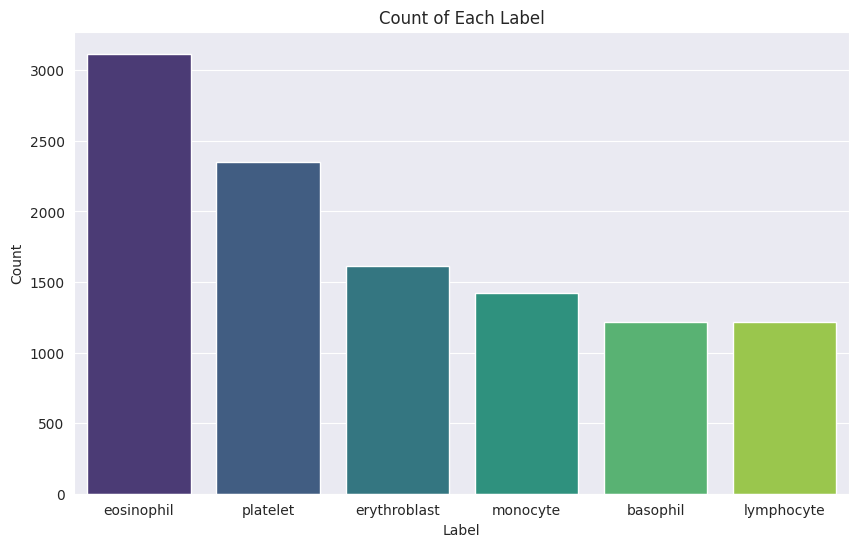

In [ ]:
# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='labels', y='count', data=labelscount, palette='viridis')

# Add title and labels
plt.title('Count of Each Label')
plt.xlabel('Label')
plt.ylabel('Count')

# Show the plot
plt.show()

In [ ]:
df

,filepaths,labels
0,/content/drive/MyDrive/bloodcells_dataset/mono...,monocyte
1,/content/drive/MyDrive/bloodcells_dataset/mono...,monocyte
2,/content/drive/MyDrive/bloodcells_dataset/mono...,monocyte
3,/content/drive/MyDrive/bloodcells_dataset/mono...,monocyte
4,/content/drive/MyDrive/bloodcells_dataset/mono...,monocyte
...,...,...
10926,/content/drive/MyDrive/bloodcells_dataset/baso...,basophil
10927,/content/drive/MyDrive/bloodcells_dataset/baso...,basophil
10928,/content/drive/MyDrive/bloodcells_dataset/baso...,basophil
10929,/content/drive/MyDrive/bloodcells_dataset/baso...,basophil


In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  test_size= 0.2, shuffle= True, random_state= 43)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 43)

In [ ]:
train_df

,filepaths,labels
3016,/content/drive/MyDrive/bloodcells_dataset/eosi...,eosinophil
1575,/content/drive/MyDrive/bloodcells_dataset/lymp...,lymphocyte
7444,/content/drive/MyDrive/bloodcells_dataset/plat...,platelet
8818,/content/drive/MyDrive/bloodcells_dataset/eryt...,erythroblast
7475,/content/drive/MyDrive/bloodcells_dataset/plat...,platelet
...,...,...
2064,/content/drive/MyDrive/bloodcells_dataset/lymp...,lymphocyte
10517,/content/drive/MyDrive/bloodcells_dataset/baso...,basophil
7985,/content/drive/MyDrive/bloodcells_dataset/plat...,platelet
2303,/content/drive/MyDrive/bloodcells_dataset/lymp...,lymphocyte


In [ ]:
dummy_df

,filepaths,labels
9259,/content/drive/MyDrive/bloodcells_dataset/eryt...,erythroblast
4673,/content/drive/MyDrive/bloodcells_dataset/eosi...,eosinophil
411,/content/drive/MyDrive/bloodcells_dataset/mono...,monocyte
8910,/content/drive/MyDrive/bloodcells_dataset/eryt...,erythroblast
10066,/content/drive/MyDrive/bloodcells_dataset/baso...,basophil
...,...,...
4448,/content/drive/MyDrive/bloodcells_dataset/eosi...,eosinophil
1268,/content/drive/MyDrive/bloodcells_dataset/mono...,monocyte
9195,/content/drive/MyDrive/bloodcells_dataset/eryt...,erythroblast
9169,/content/drive/MyDrive/bloodcells_dataset/eryt...,erythroblast


In [ ]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 8744 validated image filenames belonging to 6 classes.
Found 1093 validated image filenames belonging to 6 classes.
Found 1094 validated image filenames belonging to 6 classes.


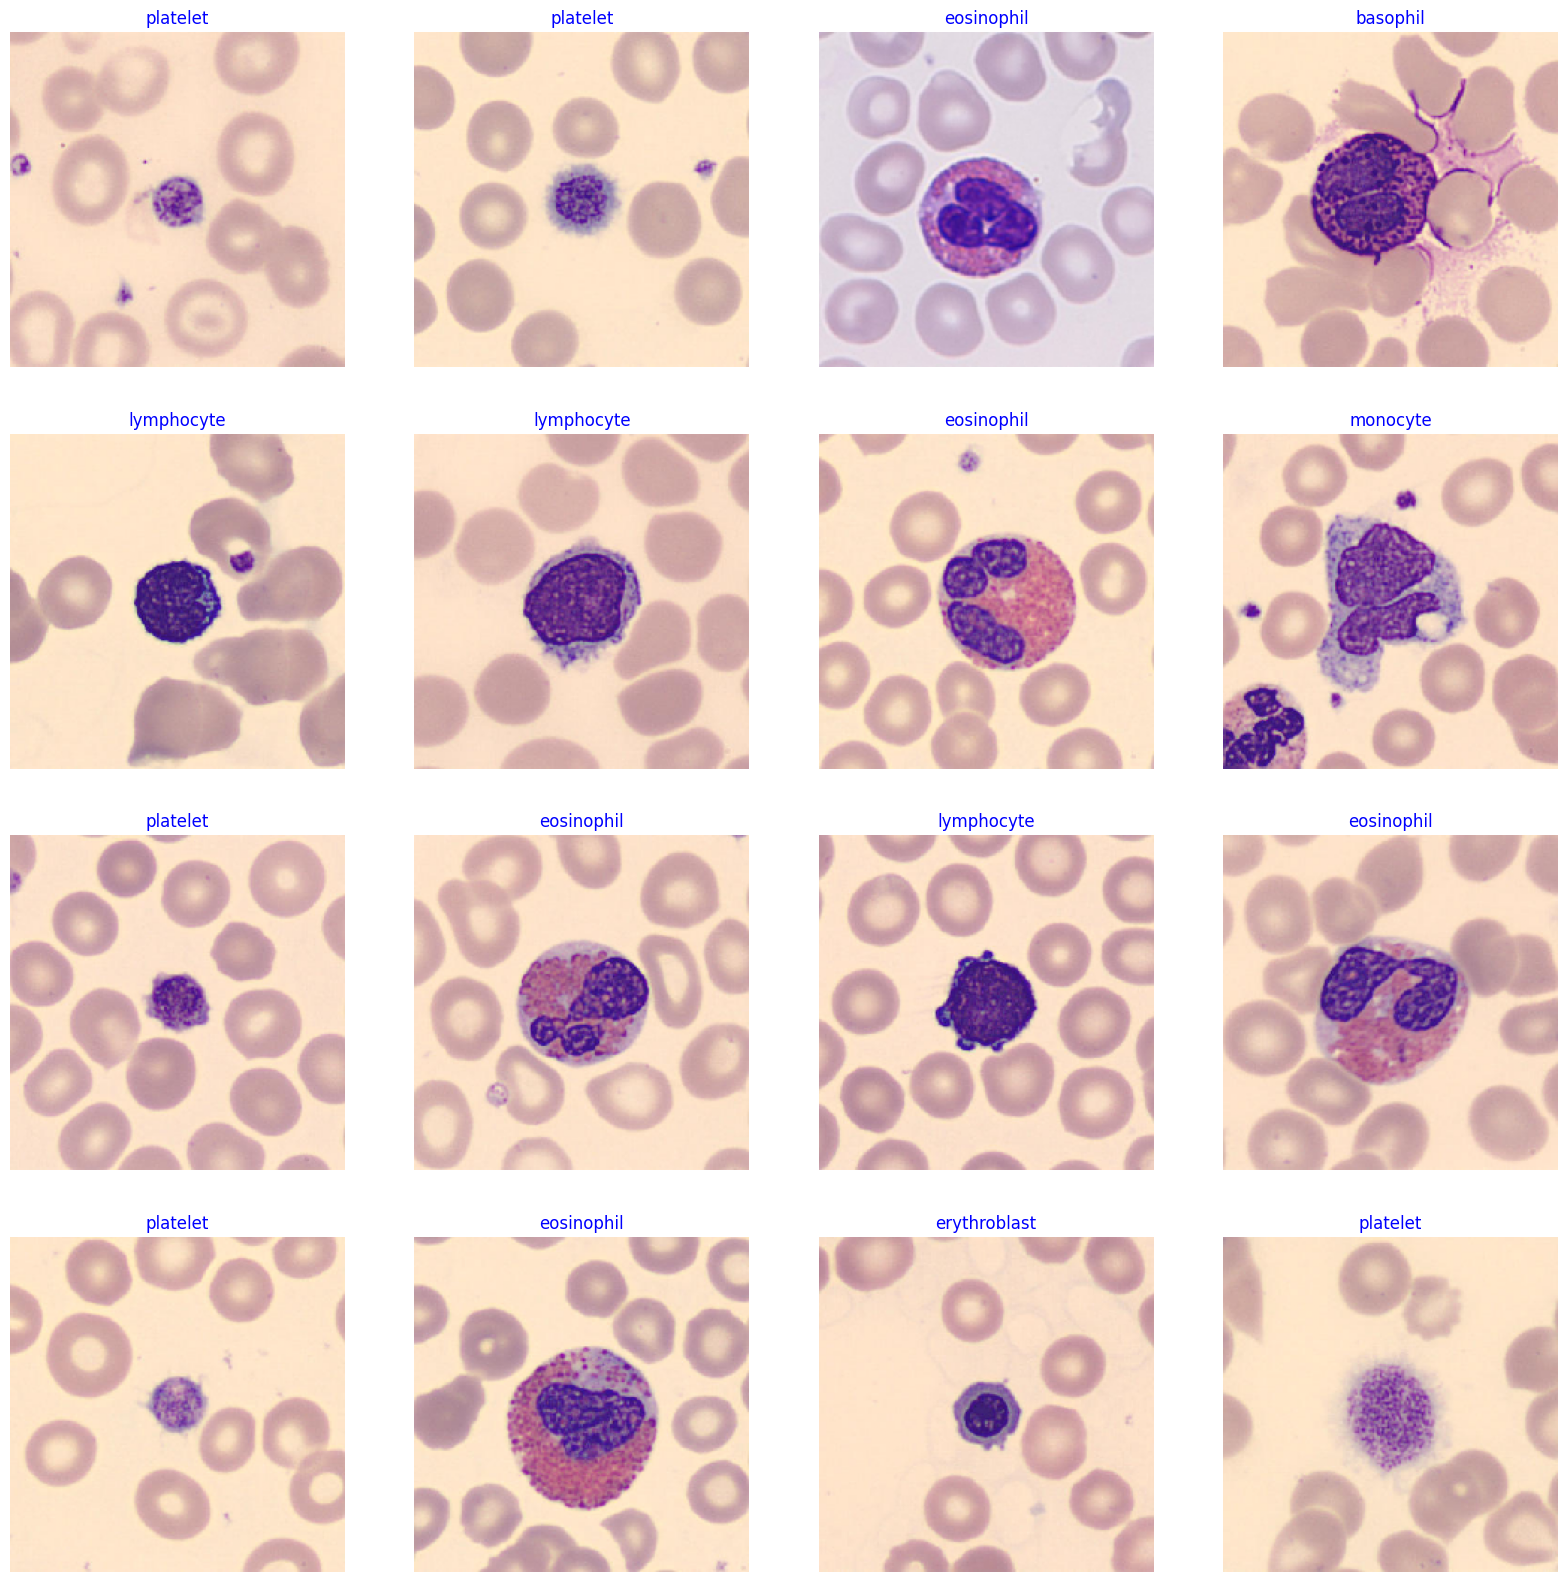

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer
model = Sequential([
    tf.keras.Input(shape=(img_size[0], img_size[1], channels)),
    tf.keras.layers.Rescaling(1./255),  # Rescale input values to [0, 1]

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_gen, epochs= 5, verbose= 1, validation_data= valid_gen, shuffle = False)

Epoch 1/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 4539s 8s/step - accuracy: 0.5959 - loss: 1.1818 - val_accuracy: 0.9378 - val_loss: 0.2203
Epoch 2/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 1119s 2s/step - accuracy: 0.9261 - loss: 0.2252 - val_accuracy: 0.9533 - val_loss: 0.1406
Epoch 3/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 1131s 2s/step - accuracy: 0.9576 - loss: 0.1249 - val_accuracy: 0.9625 - val_loss: 0.1190
Epoch 4/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 1152s 2s/step - accuracy: 0.9730 - loss: 0.0908 - val_accuracy: 0.9570 - val_loss: 0.1218
Epoch 5/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 1156s 2s/step - accuracy: 0.9774 - loss: 0.0690 - val_accuracy: 0.9689 - val_loss: 0.1006


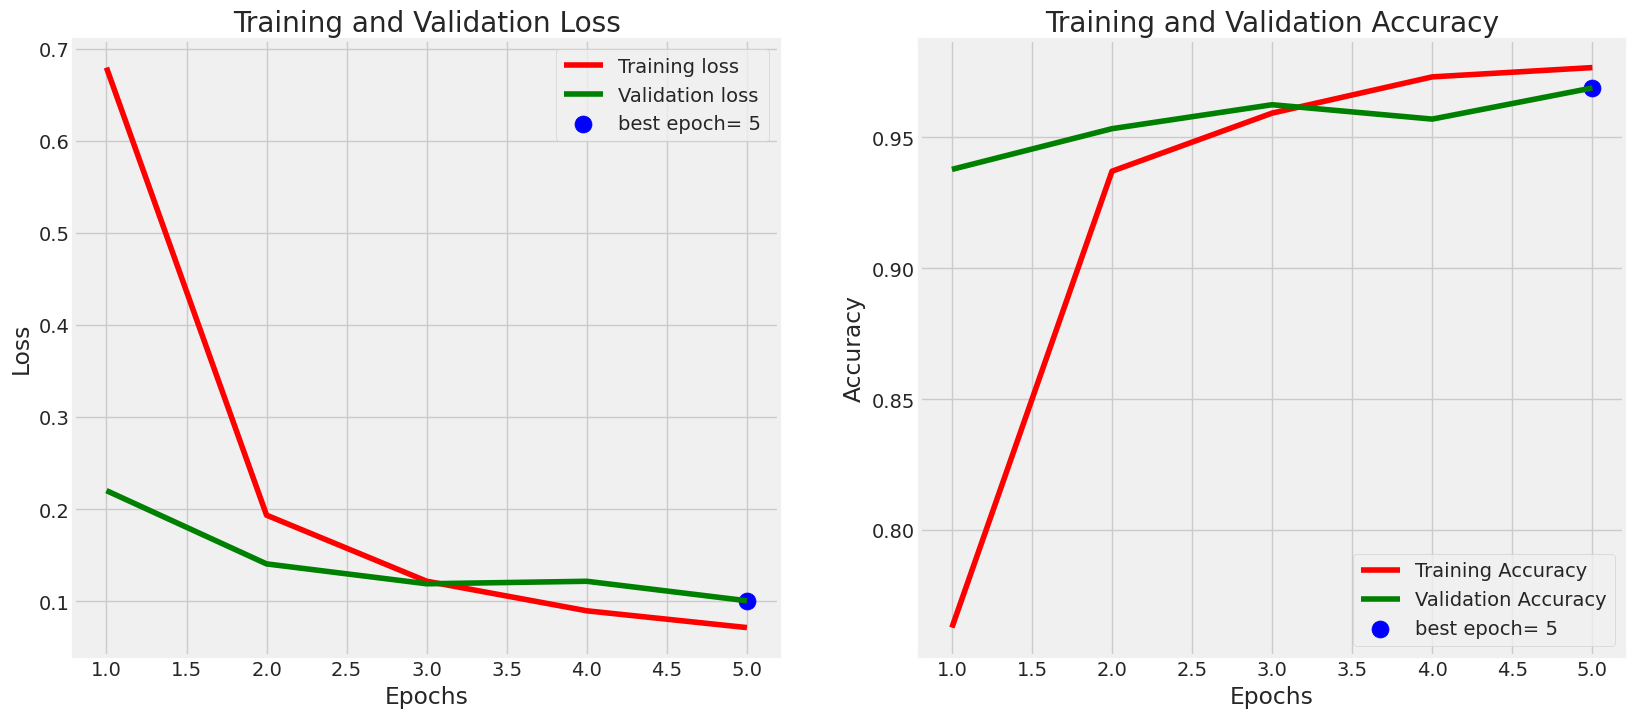

In [ ]:
 #Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

547/547 ━━━━━━━━━━━━━━━━━━━━ 322s 588ms/step - accuracy: 0.9866 - loss: 0.0444
547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - accuracy: 0.9690 - loss: 0.1043  
547/547 ━━━━━━━━━━━━━━━━━━━━ 482s 880ms/step - accuracy: 0.9722 - loss: 0.0804
Train Loss:  0.045853130519390106
Train Accuracy:  0.9869624972343445
--------------------
Validation Loss:  0.10059712827205658
Validation Accuracy:  0.9688929319381714
--------------------
Test Loss:  0.08118070662021637
Test Accuracy:  0.9716635942459106


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

69/69 ━━━━━━━━━━━━━━━━━━━━ 56s 804ms/step


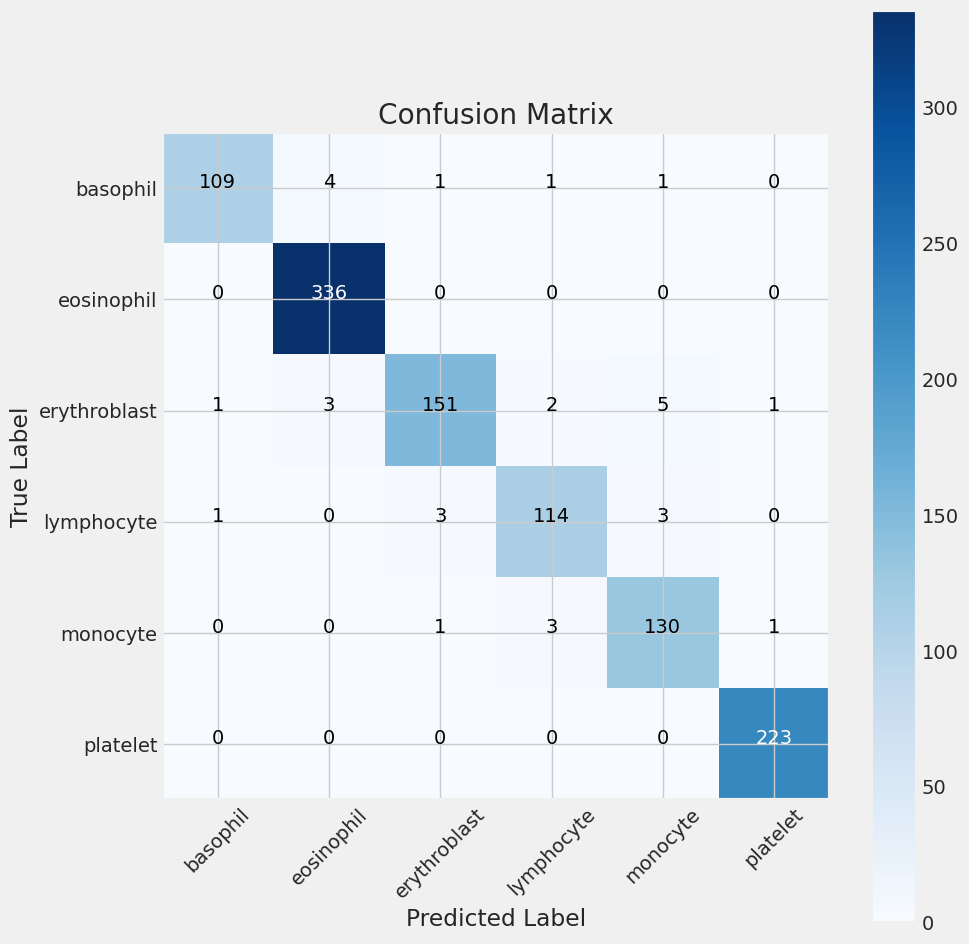

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

    basophil       0.98      0.94      0.96       116
  eosinophil       0.98      1.00      0.99       336
erythroblast       0.97      0.93      0.95       163
  lymphocyte       0.95      0.94      0.95       121
    monocyte       0.94      0.96      0.95       135
    platelet       0.99      1.00      1.00       223

    accuracy                           0.97      1094
   macro avg       0.97      0.96      0.96      1094
weighted avg       0.97      0.97      0.97      1094



In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can build on pretrained model such as : efficientnet, VGG, Resnet)
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.build(input_shape=(None, *img_shape))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,184,693 (42.67 MB)

 Trainable params: 11,094,318 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)